In [1]:
%matplotlib notebook

import PyLidar3
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import threading
import time

In [2]:
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Elapsed time for {func.__name__}: {end - start:.6f} seconds")
        return result
    return wrapper

In [3]:
#@timed
def collect_data():
    gen = Obj.StartScanning()
    data = next(gen)
    distance = []
    for points in data:
        distance.append(data[points])
    Obj.StopScanning()
    return distance

In [4]:
#@timed
def process_data(distance):
    ol.clusterOp_0.register_map

    CONTROL_REGISTER = 0x0
    ol.clusterOp_0.write(CONTROL_REGISTER, 0x81)  # 0x81 will set bit 0

    dma = ol.axi_dma
    input_buffer = allocate(shape=(360,), dtype=np.int32)
    np.copyto(input_buffer, distance)
    output_buffer = allocate(shape=(380,), dtype=np.int32)

    ol.clusterOp_0.write(CONTROL_REGISTER, 0x81)

    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()

    clusterOp_data = []
    for x in output_buffer:
        if x != 0 or output_buffer.tolist().count(x) == 1:
            clusterOp_data.append(x)

    del input_buffer, output_buffer

    return clusterOp_data

In [5]:
#@timed
def update_plot(ax1, ax2, distance, clusterOp_data):
    cluster_n = []  # initialize empty list for first cluster
    clusters = []  # initialize list to hold all clusters

    for value in clusterOp_data:
        if value == 720:
            if cluster_n:  # check if cluster_n already has values
                clusters.append(cluster_n)  # if so, add it to clusters
                cluster_n = []  # reset cluster_n to empty list
        else:
            cluster_n.append(value)  # add value to current cluster

    if cluster_n:  # handle the last cluster after the loop ends
        clusters.append(cluster_n)

    #print(clusters)  # display all clusters

    cluster_indices = [i for i, cluster in enumerate(clusters) if len(cluster) >= 5]
    ax1.clear()
    ax1.scatter(np.deg2rad(angle), distance, s=5)
    ax1.set_title("Raw Data")
    ax1.set_ylim(0, max(distance))

    ax2.clear()
    for index in cluster_indices:
        group = clusters[index]
        clusterTheta = np.array(group)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        try:
            ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)
            #print(np.deg2rad(clusterTheta))
            #print(clusterDistance)
        except Exception as e:
            print('\033[31m' +str(clusterTheta) + '\033[0m')
            #print('\033[31m' +str(clusterDistance) + '\033[0m')
    ax2.set_title("Clustered Data")
    ax2.set_ylim(0, max(distance))

    fig.canvas.draw()

In [6]:
class DataPlotter(threading.Thread):
    def __init__(self, event, iterations):
        super().__init__()
        self.event = event
        self.iterations = iterations
        self.current_iteration = 0

    def run(self):
        global distance, clusterOp_data
        while self.current_iteration < self.iterations:
            self.event.wait()
            try:
                update_plot(ax1, ax2, distance, clusterOp_data)
            except Exception as e:
                print(f"Error during iteration: {e}")
                continue
            self.current_iteration += 1
            self.event.clear()

In [7]:
angle = np.arange(0, 360)

port = "/dev/ttyUSB0"  # linux
Obj = PyLidar3.YdLidarX4(port, 12000)

if Obj.Connect():
    print(Obj.GetDeviceInfo())
else:
    print("Error connecting to device")
    exit(1)

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp/clusterOp.bit')

{'model_number': '6', 'firmware_version': '1.5', 'hardware_version': '1', 'serial_number': '201904120'}


<IPython.core.display.Javascript object>


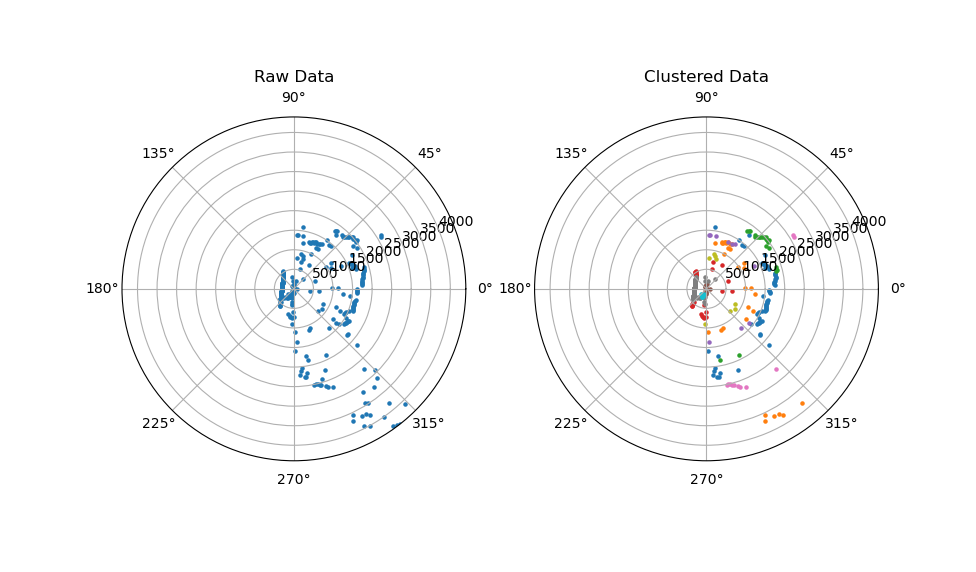

Iteration 1
Elapsed time for iteration 1: 3.385608 seconds
Iteration 2
Elapsed time for iteration 2: 3.518133 seconds
Iteration 3
Elapsed time for iteration 3: 3.703339 seconds
Iteration 4
Elapsed time for iteration 4: 3.703658 seconds
Iteration 5
Elapsed time for iteration 5: 3.729414 seconds
Iteration 6
Elapsed time for iteration 6: 3.723563 seconds
Iteration 7
Elapsed time for iteration 7: 3.705093 seconds
Iteration 8
Elapsed time for iteration 8: 3.714927 seconds
Iteration 9
Elapsed time for iteration 9: 3.813828 seconds
Iteration 10
Elapsed time for iteration 10: 3.689315 seconds
Iteration 11
Elapsed time for iteration 11: 3.748152 seconds
Iteration 12
Elapsed time for iteration 12: 3.675540 seconds
Iteration 13
Elapsed time for iteration 13: 3.699405 seconds
Iteration 14
Elapsed time for iteration 14: 3.688947 seconds
Iteration 15
Elapsed time for iteration 15: 3.683637 seconds
Iteration 16
Elapsed time for iteration 16: 3.624978 seconds
Iteration 17
Elapsed time for iteration 17

In [8]:
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))
plt.ion()

iterations = 20  # Adjust the number of iterations as needed
plot_ready_event = threading.Event()

plotter = DataPlotter(plot_ready_event, iterations)
plotter.start()

for i in range(iterations):
    start_time = time.time()
    print(f"Iteration {i + 1}")

    distance = collect_data()
    clusterOp_data = process_data(distance)

    plot_ready_event.set()  # Signal the plotter thread that data is ready to be plotted

    end_time = time.time()
    print(f"Elapsed time for iteration {i + 1}: {end_time - start_time:.6f} seconds")

plotter.join()

print("Done!")
Obj.Disconnect()